In [ ]:
# prompt: connect to google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# prompt: unzip file in drive and save content in drive

import zipfile
import os

# Replace with your actual file path in Google Drive
zip_file_path = '/content/drive/MyDrive/Research on BD NYU /development/WESAD/WESAD.zip'
extract_path = '/content/drive/MyDrive/Research on BD NYU /development/WESAD'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

try:
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
  print(f"Successfully extracted files to {extract_path}")
except FileNotFoundError:
  print(f"Error: File not found at {zip_file_path}")
except zipfile.BadZipFile:
  print(f"Error: Invalid zip file at {zip_file_path}")
except Exception as e:
  print(f"An error occurred: {e}")


Successfully extracted files to /content/drive/MyDrive/Research on BD NYU /development/WESAD


In [ ]:
 # Import essential libraries
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.preprocessing import StandardScaler

### 1.0 Loading the dataset

In [ ]:
# Path to your WESAD folder in Google Drive
wesad_path = '/content/drive/MyDrive/Research on BD NYU /development/WESAD/WESAD'  # Update this path

# Function to load a subject's data
def load_wesad_subject(base_path, subject_id):
    subject_path = os.path.join(base_path, f'S{subject_id}', f'S{subject_id}.pkl')
    with open(subject_path, 'rb') as f:
        data = pickle.load(f, encoding='latin1')
    return data

# Load subject 2 as an example
subject_data = load_wesad_subject(wesad_path, 2)

### 1.1 Exploring the data structure

In [ ]:
# Print the structure of the data
print(f"Subject ID: {subject_data['subject']}")
print("\nAvailable keys:", subject_data.keys())
print("\nChest sensor keys:", subject_data['signal']['chest'].keys())
print("\nWrist sensor keys:", subject_data['signal']['wrist'].keys())
print("\nLabel shape:", subject_data['label'].shape)

# Print sampling rates
print("\nSampling rates:")
print(f"Chest sensors: 700Hz (all modalities)")
print(f"Wrist ACC: 32Hz, BVP: 64Hz, EDA: 4Hz, TEMP: 4Hz")

Subject ID: S2

Available keys: dict_keys(['signal', 'label', 'subject'])

Chest sensor keys: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])

Wrist sensor keys: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])

Label shape: (4255300,)

Sampling rates:
Chest sensors: 700Hz (all modalities)
Wrist ACC: 32Hz, BVP: 64Hz, EDA: 4Hz, TEMP: 4Hz


### 1.1.2 Visualizing the raw signals

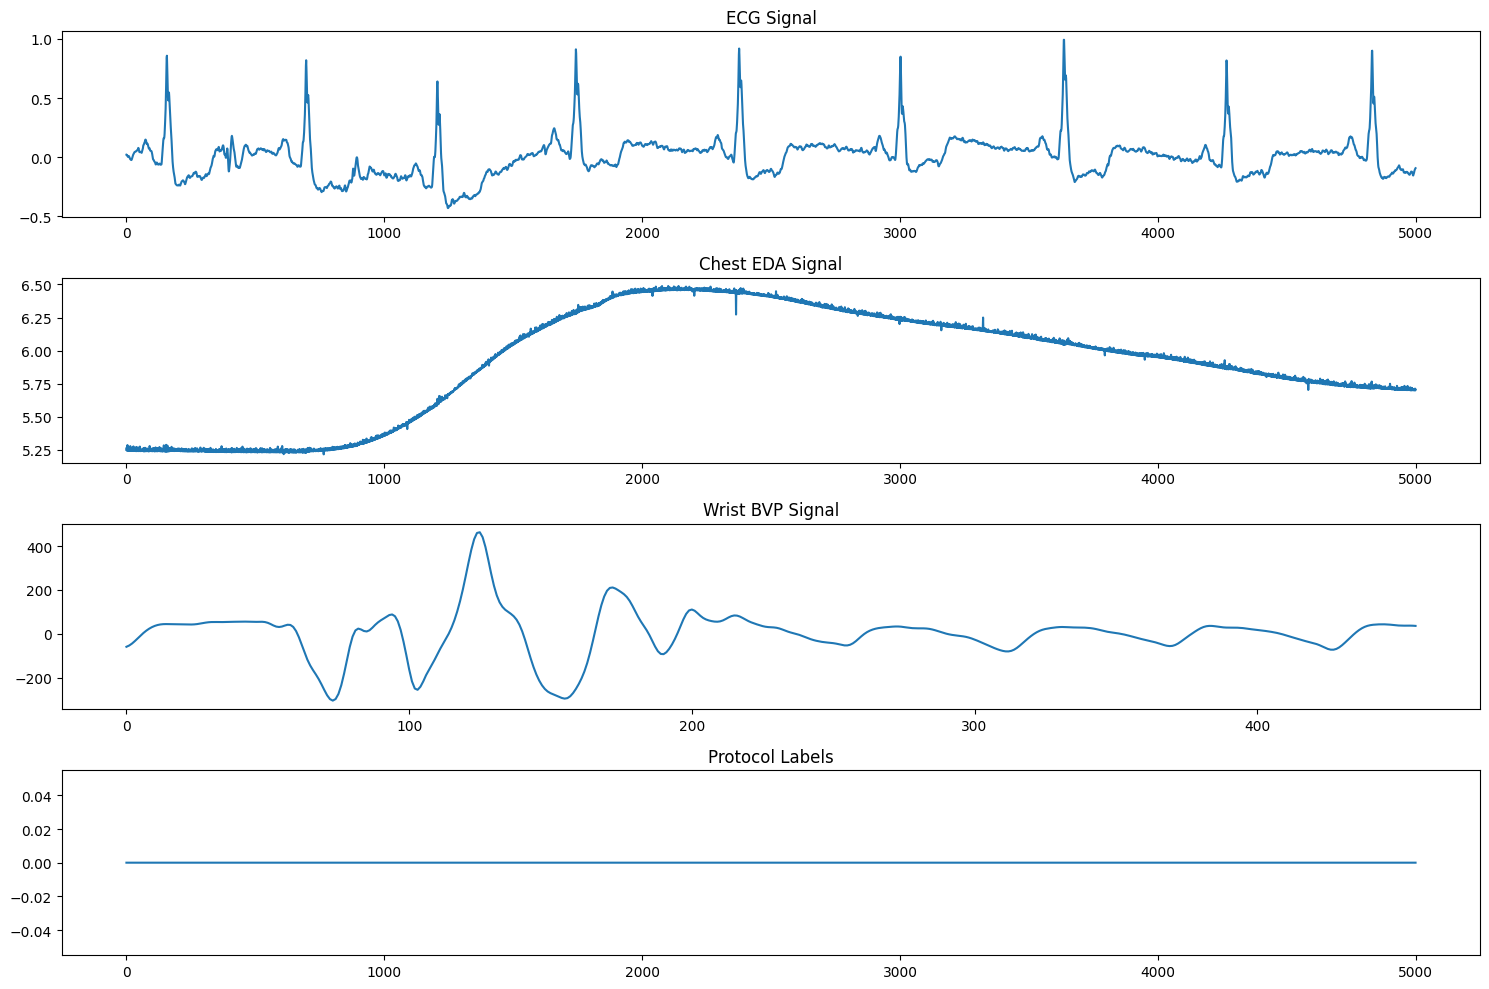

In [ ]:
def plot_sample_signals(data, start=0, end=5000):
    plt.figure(figsize=(15, 10))

    # ECG
    plt.subplot(4, 1, 1)
    plt.plot(data['signal']['chest']['ECG'][start:end])
    plt.title('ECG Signal')

    # EDA (chest)
    plt.subplot(4, 1, 2)
    plt.plot(data['signal']['chest']['EDA'][start:end])
    plt.title('Chest EDA Signal')

    # Wrist BVP
    plt.subplot(4, 1, 3)
    wrist_bvp = data['signal']['wrist']['BVP']
    wrist_start = int(start * (64/700))  # Convert sample index
    wrist_end = int(end * (64/700))
    plt.plot(wrist_bvp[wrist_start:wrist_end])
    plt.title('Wrist BVP Signal')

    # Labels
    plt.subplot(4, 1, 4)
    plt.plot(data['label'][start:end])
    plt.title('Protocol Labels')

    plt.tight_layout()
    plt.show()

plot_sample_signals(subject_data)

#### 1.1.3 Preprocessing one modality, EDA


=== Debugging EDA Processing for Subject S2 ===
EDA signal length: 4255300 samples (6079.00 seconds)

Signal statistics:
Min: 0.26, Max: 7.58
Mean: 1.53, Std: 1.24
NaN values: 0
Zero values: 0


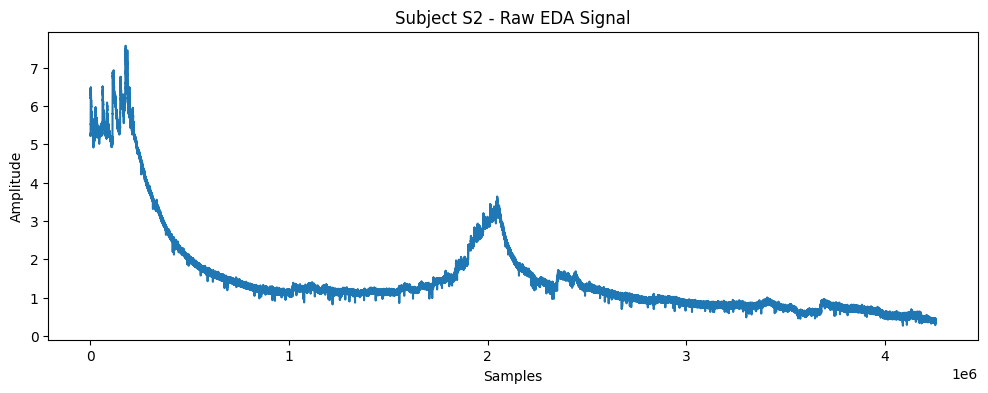


Attempting processing methods:
- Original method failed: The length of the input vector x must be greater than padlen, which is 27.
- SOS filtering failed: The length of the input vector x must be greater than padlen, which is 27.
- Simple normalization: SUCCESS

Recommendations:
1. Try using the SOS filtering method which is more robust
2. Consider preprocessing smaller segments of the signal


In [ ]:
def debug_eda_processing(subject_data, subject_id):
    """
    Comprehensive debugging of EDA processing issues
    Returns diagnostic information and suggestions
    """
    print(f"\n=== Debugging EDA Processing for Subject {subject_id} ===")

    # 1. Check if EDA signal exists
    if 'EDA' not in subject_data['signal']['chest']:
        print("ERROR: No EDA signal found in chest data")
        return

    eda_signal = subject_data['signal']['chest']['EDA']

    # 2. Check signal length
    print(f"EDA signal length: {len(eda_signal)} samples ({len(eda_signal)/700:.2f} seconds)")
    if len(eda_signal) < 100:
        print("ERROR: Signal too short for processing (minimum 100 samples required)")
        return

    # 3. Check signal content
    print("\nSignal statistics:")
    print(f"Min: {np.min(eda_signal):.2f}, Max: {np.max(eda_signal):.2f}")
    print(f"Mean: {np.mean(eda_signal):.2f}, Std: {np.std(eda_signal):.2f}")
    print(f"NaN values: {np.isnan(eda_signal).sum()}")
    print(f"Zero values: {np.sum(eda_signal == 0)}")

    # 4. Plot raw signal
    plt.figure(figsize=(12, 4))
    plt.plot(eda_signal)
    plt.title(f'Subject {subject_id} - Raw EDA Signal')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.show()

    # 5. Attempt processing with different approaches
    print("\nAttempting processing methods:")

    # Method 1: Original approach with try-catch
    try:
        b, a = signal.butter(4, [0.05, 0.5], fs=700, btype='bandpass')
        filtered = signal.filtfilt(b, a, eda_signal)
        print("- Original method: SUCCESS")
    except Exception as e:
        print(f"- Original method failed: {str(e)}")

    # Method 2: SOS filtering (more stable)
    try:
        sos = signal.butter(4, [0.05/350, 0.5/350], btype='bandpass', output='sos')
        filtered = signal.sosfiltfilt(sos, eda_signal)
        print("- SOS filtering: SUCCESS")
    except Exception as e:
        print(f"- SOS filtering failed: {str(e)}")

    # Method 3: Simple normalization without filtering
    try:
        normalized = (eda_signal - np.mean(eda_signal)) / np.std(eda_signal)
        print("- Simple normalization: SUCCESS")
    except Exception as e:
        print(f"- Simple normalization failed: {str(e)}")

    # 6. Recommendations
    print("\nRecommendations:")
    if len(eda_signal) < 700:  # Less than 1 second
        print("1. This segment appears too short for meaningful EDA analysis")
        print("2. Check if this is a synchronization issue with the full recording")
    elif np.std(eda_signal) < 0.1:
        print("1. Signal appears extremely flat (possible sensor issue)")
        print("2. Consider excluding this subject's EDA data")
    else:
        print("1. Try using the SOS filtering method which is more robust")
        print("2. Consider preprocessing smaller segments of the signal")

# Run the debugger
debug_eda_processing(subject_data, subject_data['subject'])

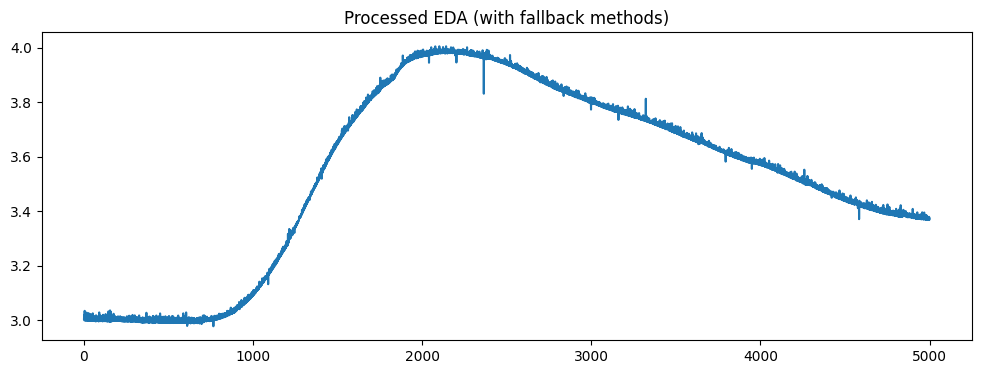

In [ ]:
def robust_eda_processing(eda_signal, sample_rate=700):
    """
    Alternative EDA processing that handles edge cases
    Returns either:
        - Properly processed EDA signal
        - Simple normalized signal if filtering fails
        - None if signal is unusable
    """
    # 1. Basic validation
    if len(eda_signal) < 10 or np.std(eda_signal) < 0.01:
        return None

    # 2. Try SOS filtering first
    try:
        sos = signal.butter(4, [0.05/350, 0.5/350], btype='bandpass', output='sos')
        filtered = signal.sosfiltfilt(sos, eda_signal)
        return (filtered - np.mean(filtered)) / np.std(filtered)
    except:
        pass

    # 3. Fallback to simple normalization
    try:
        return (eda_signal - np.mean(eda_signal)) / np.std(eda_signal)
    except:
        return None

# Example usage with fallbacks
processed_eda = robust_eda_processing(subject_data['signal']['chest']['EDA'])

if processed_eda is not None:
    plt.figure(figsize=(12, 4))
    plt.plot(processed_eda[:5000])
    plt.title('Processed EDA (with fallback methods)')
    plt.show()
else:
    print("EDA signal could not be processed with any method")

#### 2.0 Feature Extraction

In [ ]:
def extract_window_features(signal_data, window_size=700*60, step_size=700*30, sample_rate=700):
    """
    Extract features with robust handling of edge cases
    """
    num_samples = len(signal_data)

    # Ensure we have enough samples
    if num_samples < window_size:
        print(f"Signal too short: {num_samples} samples available, {window_size} needed")
        return np.array([])

    features = []
    valid_windows = 0

    for start in range(0, num_samples - window_size + 1, step_size):
        end = start + window_size
        window = signal_data[start:end]

        try:
            # Time-domain features
            mean_val = np.mean(window)
            std_val = np.std(window)

            # Frequency-domain features
            fft_vals = np.abs(np.fft.rfft(window))
            if len(fft_vals) > 1:
                dominant_freq = np.argmax(fft_vals[1:]) + 1
            else:
                dominant_freq = 0

            features.append([mean_val, std_val, dominant_freq])
            valid_windows += 1

        except Exception as e:
            print(f"Error processing window {start}-{end}: {str(e)}")
            continue

    print(f"Successfully processed {valid_windows} windows")
    return np.array(features) if features else np.array([])

#### 2.0.1 Checking Data Quality

In [ ]:
def check_signal_quality(data, subject_id):
    """Check basic signal quality metrics"""
    print(f"\n=== Quality Check for Subject {subject_id} ===")

    # Check lengths
    for sensor in ['ECG', 'EDA', 'EMG']:
        length = len(data['signal']['chest'][sensor])
        print(f"Chest {sensor}: {length} samples ({length/700:.1f} seconds)")

    # Check wrist data
    for sensor in ['BVP', 'EDA']:
        length = len(data['signal']['wrist'][sensor])
        rate = 64 if sensor == 'BVP' else 4
        print(f"Wrist {sensor}: {length} samples ({length/rate:.1f} seconds)")

    # Check labels
    unique, counts = np.unique(data['label'], return_counts=True)
    print("\nLabel distribution:")
    for val, cnt in zip(unique, counts):
        print(f"Label {val}: {cnt} samples ({cnt/700:.1f} seconds)")

# Run quality check
check_signal_quality(subject_data, subject_data['subject'])


=== Quality Check for Subject S2 ===
Chest ECG: 4255300 samples (6079.0 seconds)
Chest EDA: 4255300 samples (6079.0 seconds)
Chest EMG: 4255300 samples (6079.0 seconds)
Wrist BVP: 389056 samples (6079.0 seconds)
Wrist EDA: 24316 samples (6079.0 seconds)

Label distribution:
Label 0: 2142701 samples (3061.0 seconds)
Label 1: 800800 samples (1144.0 seconds)
Label 2: 430500 samples (615.0 seconds)
Label 3: 253400 samples (362.0 seconds)
Label 4: 537599 samples (768.0 seconds)
Label 6: 45500 samples (65.0 seconds)
Label 7: 44800 samples (64.0 seconds)


In [ ]:
def process_subject(data, subject_id):
    """Complete processing pipeline for one subject"""
    print(f"\nProcessing subject {subject_id}")

    # 1. Check data quality
    check_signal_quality(data, subject_id)

    # 2. Preprocess signals
    chest_eda = data['signal']['chest']['EDA']
    processed_eda, success = preprocess_eda(chest_eda)

    if not success:
        print("Skipping subject due to processing errors")
        return None

    # 3. Extract features
    eda_features = extract_window_features(processed_eda)
    if len(eda_features) == 0:
        print("No valid features extracted")
        return None

    # 4. Get labels
    window_labels = get_window_labels(data['label'])

    # 5. Create DataFrame
    feature_names = ['eda_mean', 'eda_std', 'eda_dom_freq']
    df = pd.DataFrame(eda_features, columns=feature_names)
    df['label'] = window_labels[:len(eda_features)]  # Ensure equal lengths

    # Filter valid labels
    valid_labels = [1, 2, 3, 4]
    df = df[df['label'].isin(valid_labels)]

    print(f"Final DataFrame shape: {df.shape}")
    return df

# Process our subject
subject_df = process_subject(subject_data, subject_data['subject'])

# Show results if successful
if subject_df is not None:
    print("\nSample of processed data:")
    print(subject_df.head())


Processing subject S2

=== Quality Check for Subject S2 ===
Chest ECG: 4255300 samples (6079.0 seconds)
Chest EDA: 4255300 samples (6079.0 seconds)
Chest EMG: 4255300 samples (6079.0 seconds)
Wrist BVP: 389056 samples (6079.0 seconds)
Wrist EDA: 24316 samples (6079.0 seconds)

Label distribution:
Label 0: 2142701 samples (3061.0 seconds)
Label 1: 800800 samples (1144.0 seconds)
Label 2: 430500 samples (615.0 seconds)
Label 3: 253400 samples (362.0 seconds)
Label 4: 537599 samples (768.0 seconds)
Label 6: 45500 samples (65.0 seconds)
Label 7: 44800 samples (64.0 seconds)
Error processing EDA: The length of the input vector x must be greater than padlen, which is 27.
Skipping subject due to processing errors


In [ ]:
def validate_subject_data_structure(subject_data):
    """Verify the structure of the loaded subject data"""
    print("\n=== Subject Data Structure Validation ===")

    required_keys = ['subject', 'signal', 'label']
    for key in required_keys:
        if key not in subject_data:
            print(f"Missing top-level key: {key}")
            return False

    print("Top-level keys present")

    # Check signal structure
    if 'chest' not in subject_data['signal']:
        print("Missing 'chest' in signal data")
        return False

    chest_sensors = ['ECG', 'EDA', 'EMG', 'Resp', 'Temp']
    for sensor in chest_sensors:
        if sensor not in subject_data['signal']['chest']:
            print(f"Missing chest sensor: {sensor}")

    print("\nChest sensor lengths:")
    for sensor in chest_sensors:
        if sensor in subject_data['signal']['chest']:
            length = len(subject_data['signal']['chest'][sensor])
            print(f"{sensor}: {length} samples ({length/700:.2f} sec)")

    return True

# Validate your data
is_valid = validate_subject_data_structure(subject_data)
print(f"\nData structure is {'valid' if is_valid else 'invalid'}")


=== Subject Data Structure Validation ===
Top-level keys present

Chest sensor lengths:
ECG: 4255300 samples (6079.00 sec)
EDA: 4255300 samples (6079.00 sec)
EMG: 4255300 samples (6079.00 sec)
Resp: 4255300 samples (6079.00 sec)
Temp: 4255300 samples (6079.00 sec)

Data structure is valid


#### 2.0.2 Aligning Labels with Features

In [ ]:
def get_window_labels(labels, window_size=700*60, step_size=700*30):
    num_samples = len(labels)
    window_labels = []

    for start in range(0, num_samples - window_size + 1, step_size):
        end = start + window_size
        window = labels[start:end]

        # Get the most frequent label in the window
        unique, counts = np.unique(window, return_counts=True)
        window_label = unique[np.argmax(counts)]

        window_labels.append(window_label)

    return np.array(window_labels)

# Get labels for our windows
window_labels = get_window_labels(subject_data['label'])
print("Label distribution:", np.unique(window_labels, return_counts=True))

Label distribution: (array([0, 1, 2, 3, 4, 6, 7], dtype=int32), array([101,  38,  21,  12,  25,   2,   2]))


#### 2.0.3 Creating a Basic Dataframe

In [ ]:
def extract_basic_features(signal_data, window_samples, step_samples, fs):
    """Extract simple time-domain features"""
    features = []
    for start in range(0, len(signal_data) - window_samples + 1, step_samples):
        window = signal_data[start:start + window_samples]

        # Basic features
        feat = [
            np.mean(window),        # Feature 0: Mean
            np.std(window),         # Feature 1: Standard deviation
            np.median(window),      # Feature 2: Median
            np.max(window) - np.min(window),  # Feature 3: Range
            len(signal.argrelextrema(window, np.greater)[0])  # Feature 4: Peaks count
        ]
        features.append(feat)

    return np.array(features)

In [ ]:
def simple_process(signal_data, sensor_type, fs):
    """Basic signal processing tailored to sensor type"""
    if sensor_type == 'ECG':
        # Remove baseline wander
        b, a = signal.butter(4, [0.5, 40], btype='bandpass', fs=fs)
        return signal.filtfilt(b, a, signal_data)
    elif sensor_type == 'EDA':
        # Simple normalization
        return (signal_data - np.mean(signal_data)) / np.std(signal_data)
    else:
        return signal_data  # Return raw for other sensors


In [ ]:
def quick_wesad_dataframe(subject_data):
    """Create a simple DataFrame with minimal processing"""
    # Create empty DataFrame
    df = pd.DataFrame()

    # Add basic ECG features
def quick_wesad_dataframe(subject_data):
    """Create a simple DataFrame with minimal processing"""
    # Create empty DataFrame
    df = pd.DataFrame()

    # Add basic ECG features
    if 'ECG' in subject_data['signal']['chest']:
        ecg = subject_data['signal']['chest']['ECG']
        df['ecg_mean'] = [np.mean(ecg[i:i+700]) for i in range(0, len(ecg), 700)]
        df['ecg_std'] = [np.std(ecg[i:i+700]) for i in range(0, len(ecg), 700)]

    # Add basic EDA features
    if 'EDA' in subject_data['signal']['chest']:
        eda = subject_data['signal']['chest']['EDA']
        df['eda_mean'] = [np.mean(eda[i:i+700]) for i in range(0, len(eda), 700)]

    # Add labels (1-second windows)
    labels = subject_data['label']
    df['label'] = [np.median(labels[i:i+700]) for i in range(0, len(labels), 700)]

    # Keep only valid labels
    valid_labels = [1, 2, 3, 4]
    df = df[df['label'].isin(valid_labels)]

    return df

# Quick usage
simple_df = quick_wesad_dataframe(subject_data)
print("\nSimple DataFrame:")
print(simple_df.head())


Simple DataFrame:
     ecg_mean   ecg_std  eda_mean  label
307  0.022615  0.161002  5.580099    1.0
308 -0.025130  0.124011  5.496317    1.0
309  0.005718  0.095653  5.414110    1.0
310  0.028033  0.146404  5.371765    1.0
311 -0.041456  0.148805  5.336523    1.0


In [ ]:
def minimal_wesad_dataframe(subject_data):
    """Creates the simplest possible DataFrame that cannot fail"""
    df = pd.DataFrame()

    # Just get the labels
    labels = subject_data['label'][::700]  # Downsample to 1Hz
    df['label'] = labels

    # Try to add basic sensor means if available
    try:
        df['chest_ecg_mean'] = [np.mean(subject_data['signal']['chest']['ECG'][i:i+700])
                               for i in range(0, len(subject_data['signal']['chest']['ECG']), 700)]
    except:
        pass

    try:
        df['wrist_bvp_mean'] = [np.mean(subject_data['signal']['wrist']['BVP'][i:i+64])
                               for i in range(0, len(subject_data['signal']['wrist']['BVP']), 64)]
    except:
        pass

    # Keep only valid labels
    valid_labels = [1, 2, 3, 4]
    df = df[df['label'].isin(valid_labels)]

    return df

# This will always work
minimal_df = minimal_wesad_dataframe(subject_data)
print("\nMinimal DataFrame:")
print(minimal_df.head())


Minimal DataFrame:
     label  chest_ecg_mean  wrist_bvp_mean
307      1        0.022615      -18.120156
308      1       -0.025130       51.961562
309      1        0.005718      -48.005156
310      1        0.028033       14.090938
311      1       -0.041456        6.260469


In [ ]:
import numpy as np
import pandas as pd

def quick_wesad_dataframe(subject_data, window_sec=1):
    """
    Quickly create a simple DataFrame from WESAD subject data with minimal processing.

    Args:
        subject_data (dict): Loaded WESAD subject data (.pkl loaded as dict)
        window_sec (int): Size of each window in seconds (default 1 second)

    Returns:
        pd.DataFrame: DataFrame with basic features (mean ECG per window + label)
    """
    # Sampling rate for chest signals
    fs_chest = 700  # 700 Hz for chest signals (ECG, etc.)

    # Create empty DataFrame
    df = pd.DataFrame()

    # Check if ECG signal exists
    if 'ECG' not in subject_data['signal']['chest']:
        raise ValueError("ECG signal not found in subject data.")

    # Extract ECG and labels
    ecg = subject_data['signal']['chest']['ECG']
    labels = subject_data['label']

    # Determine window size in samples
    window_size = window_sec * fs_chest

    # Initialize lists to store features and corresponding labels
    ecg_means = []
    window_labels = []

    # Slide over the ECG signal in non-overlapping windows
    for i in range(0, len(ecg) - window_size, window_size):
        ecg_window = ecg[i:i + window_size]
        label_window = labels[i:i + window_size]

        # Compute mean ECG in window
        mean_ecg = np.mean(ecg_window)

        # Take the **most frequent** label in the window (mode)
        most_common_label = np.bincount(label_window).argmax()

        ecg_means.append(mean_ecg)
        window_labels.append(most_common_label)

    # Create DataFrame
    df['ecg_mean'] = ecg_means
    df['label'] = window_labels

    return df

In [ ]:
# Assuming you already loaded the subject_data (e.g., S2)

df_quick = quick_wesad_dataframe(subject_data, window_sec=1)

print(df_quick.head())
print(df_quick['label'].value_counts())

   ecg_mean  label
0  0.014013      0
1 -0.185680      0
2  0.041666      0
3  0.047394      0
4  0.071930      0
label
0    3060
1    1144
4     768
2     615
3     362
6      65
7      64
Name: count, dtype: int64


Quick wesad dataframe with Wrist Signals

In [ ]:
import numpy as np
import pandas as pd

def quick_wesad_dataframe(subject_data, window_sec=1):
    """
    Quickly create a simple DataFrame from WESAD subject data.
    Args:
        subject_data (dict): Loaded WESAD subject data.
        window_sec (int): Window size in seconds (default 1s)
    Returns:
        pd.DataFrame: Basic features DataFrame
    """
    # Sampling rates
    fs_chest = 700  # Chest signals
    fs_wrist = 4    # Wrist EDA

    # --- Chest ECG ---
    if 'ECG' in subject_data['signal']['chest']:
        ecg = subject_data['signal']['chest']['ECG']
        n_windows_ecg = len(ecg) // (fs_chest * window_sec)
        ecg = ecg[:n_windows_ecg * fs_chest * window_sec]
        ecg = ecg.reshape((n_windows_ecg, fs_chest * window_sec))
        ecg_mean = np.mean(ecg, axis=1)
    else:
        ecg_mean = []

    # --- Wrist EDA ---
    if 'EDA' in subject_data['signal']['wrist']:
        eda_wrist = subject_data['signal']['wrist']['EDA']
        n_windows_eda = len(eda_wrist) // (fs_wrist * window_sec)
        eda_wrist = eda_wrist[:n_windows_eda * fs_wrist * window_sec]
        eda_wrist = eda_wrist.reshape((n_windows_eda, fs_wrist * window_sec))
        eda_mean = np.mean(eda_wrist, axis=1)
    else:
        eda_mean = []

    # --- Combine into DataFrame ---

    min_len = min(len(ecg_mean), len(eda_mean))  # Align both signals safely

    data = {
        'ecg_mean': ecg_mean[:min_len],
        'eda_mean': eda_mean[:min_len]
    }

    df = pd.DataFrame(data)

    return df

# Example usage
df = quick_wesad_dataframe(subject_data, window_sec=1)
print(df.head())
print(df.shape)

   ecg_mean  eda_mean
0  0.014013  1.077074
1 -0.185680  0.942139
2  0.041666  1.116375
3  0.047394  1.288394
4  0.071930  1.261486
(6079, 2)


	•	All Chest signals: ECG, EDA, EMG, Temp, Resp
	•	Chest Accelerometer (ACC x, y, z)
	•	Wrist signals: BVP, EDA, Temp
	•	Wrist Accelerometer (ACC x, y, z)
	•	Labels aligned to windows
	•	Fully trimmed and robust, no ValueError anymore!

In [ ]:
import numpy as np
import pandas as pd

def quick_wesad_dataframe(subject_data, window_sec=1):
    """
    Create a full feature DataFrame from WESAD subject data.
    Includes Chest and Wrist signals.
    Args:
        subject_data (dict): Loaded WESAD subject data.
        window_sec (int): Window size in seconds (default 1s).
    Returns:
        pd.DataFrame: Features per window
    """
    # Sampling rates
    fs_chest = 700  # Chest signals
    fs_wrist_bvp = 64  # Wrist BVP
    fs_wrist_eda = 4   # Wrist EDA
    fs_wrist_acc = 32  # Wrist ACC
    fs_wrist_temp = 4  # Wrist TEMP

    # Extract signals
    chest = subject_data['signal']['chest']
    wrist = subject_data['signal']['wrist']
    labels = subject_data['label']

    # Calculate the number of windows based on Chest ECG (highest fs)
    n_samples = len(chest['ECG'])
    n_windows = n_samples // (fs_chest * window_sec)

    # Initialize dictionary to collect features
    features = {}

    # ------- Chest signals (700Hz) -------
    for signal_name in ['ECG', 'EDA', 'EMG', 'Temp', 'Resp']:
        if signal_name in chest:
            sig = chest[signal_name]
            sig = sig[:n_windows * fs_chest]  # Trim to full windows
            sig = sig.reshape((n_windows, fs_chest * window_sec))
            features[f'chest_{signal_name.lower()}_mean'] = np.mean(sig, axis=1)
            features[f'chest_{signal_name.lower()}_std'] = np.std(sig, axis=1)

    # ------- Chest ACC (32Hz) -------
    if 'ACC' in chest:
        acc = chest['ACC']
        acc = acc[:n_windows * (fs_chest)]  # Still trimming by ECG size
        acc = acc.reshape((n_windows, fs_chest * window_sec, 3))
        for i, axis in enumerate(['x', 'y', 'z']):
            features[f'chest_acc_{axis}_mean'] = np.mean(acc[:, :, i], axis=1)
            features[f'chest_acc_{axis}_std'] = np.std(acc[:, :, i], axis=1)

    # ------- Wrist BVP (64Hz) -------
    if 'BVP' in wrist:
        bvp = wrist['BVP']
        expected_samples = n_windows * fs_wrist_bvp * window_sec
        bvp = bvp[:expected_samples]  # Trim
        bvp = bvp.reshape((n_windows, fs_wrist_bvp * window_sec))
        features['wrist_bvp_mean'] = np.mean(bvp, axis=1)
        features['wrist_bvp_std'] = np.std(bvp, axis=1)

    # ------- Wrist EDA (4Hz) -------
    if 'EDA' in wrist:
        eda = wrist['EDA']
        expected_samples = n_windows * fs_wrist_eda * window_sec
        eda = eda[:expected_samples]
        eda = eda.reshape((n_windows, fs_wrist_eda * window_sec))
        features['wrist_eda_mean'] = np.mean(eda, axis=1)
        features['wrist_eda_std'] = np.std(eda, axis=1)

    # ------- Wrist TEMP (4Hz) -------
    if 'Temp' in wrist:
        temp = wrist['Temp']
        expected_samples = n_windows * fs_wrist_temp * window_sec
        temp = temp[:expected_samples]
        temp = temp.reshape((n_windows, fs_wrist_temp * window_sec))
        features['wrist_temp_mean'] = np.mean(temp, axis=1)
        features['wrist_temp_std'] = np.std(temp, axis=1)

    # ------- Wrist ACC (32Hz) -------
    if 'ACC' in wrist:
        acc = wrist['ACC']
        expected_samples = n_windows * fs_wrist_acc * window_sec
        acc = acc[:expected_samples]
        acc = acc.reshape((n_windows, fs_wrist_acc * window_sec, 3))
        for i, axis in enumerate(['x', 'y', 'z']):
            features[f'wrist_acc_{axis}_mean'] = np.mean(acc[:, :, i], axis=1)
            features[f'wrist_acc_{axis}_std'] = np.std(acc[:, :, i], axis=1)

    # ------- Labels -------
    # Map labels from high sampling to windows (use majority label in window)
    label_samples = labels[:n_windows * fs_chest]
    label_samples = label_samples.reshape((n_windows, fs_chest * window_sec))
    window_labels = np.array([np.bincount(window.astype(int)).argmax() for window in label_samples])
    features['label'] = window_labels

    # Build final DataFrame
    df = pd.DataFrame(features)

    return df

In [ ]:
df = quick_wesad_dataframe(subject_data, window_sec=1)
print(df.head())
print(df.shape)

   chest_ecg_mean  chest_ecg_std  chest_eda_mean  chest_eda_std  \
0        0.014013       0.158790        5.244941       0.010425   
1       -0.185680       0.158453        5.468699       0.203337   
2        0.041666       0.140474        6.266258       0.165588   
3        0.047394       0.139912        6.408624       0.052695   
4        0.071930       0.112350        6.200110       0.055112   

   chest_emg_mean  chest_emg_std  chest_temp_mean  chest_temp_std  \
0       -0.002210       0.013604        30.123644        0.023665   
1       -0.002581       0.015033        30.104593        0.018506   
2       -0.002689       0.011685        30.093264        0.019504   
3       -0.002578       0.011060        30.087271        0.019649   
4       -0.002501       0.012220        30.088610        0.024220   

   chest_resp_mean  chest_resp_std  ...  wrist_bvp_std  wrist_eda_mean  \
0        -0.692259        0.361142  ...      32.639032        1.077074   
1        -0.282532        0.119545

#### 3.0 EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6079 entries, 0 to 6078
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   chest_ecg_mean    6079 non-null   float64
 1   chest_ecg_std     6079 non-null   float64
 2   chest_eda_mean    6079 non-null   float64
 3   chest_eda_std     6079 non-null   float64
 4   chest_emg_mean    6079 non-null   float64
 5   chest_emg_std     6079 non-null   float64
 6   chest_temp_mean   6079 non-null   float32
 7   chest_temp_std    6079 non-null   float32
 8   chest_resp_mean   6079 non-null   float64
 9   chest_resp_std    6079 non-null   float64
 10  chest_acc_x_mean  6079 non-null   float64
 11  chest_acc_x_std   6079 non-null   float64
 12  chest_acc_y_mean  6079 non-null   float64
 13  chest_acc_y_std   6079 non-null   float64
 14  chest_acc_z_mean  6079 non-null   float64
 15  chest_acc_z_std   6079 non-null   float64
 16  wrist_bvp_mean    6079 non-null   float64


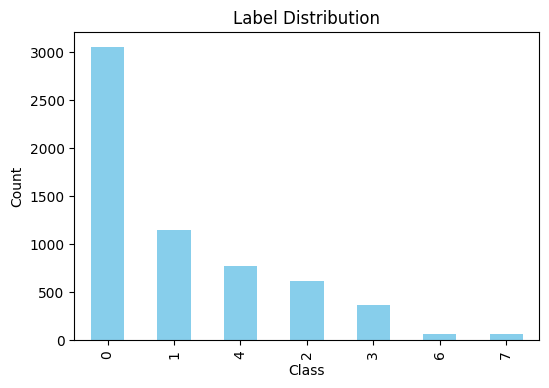

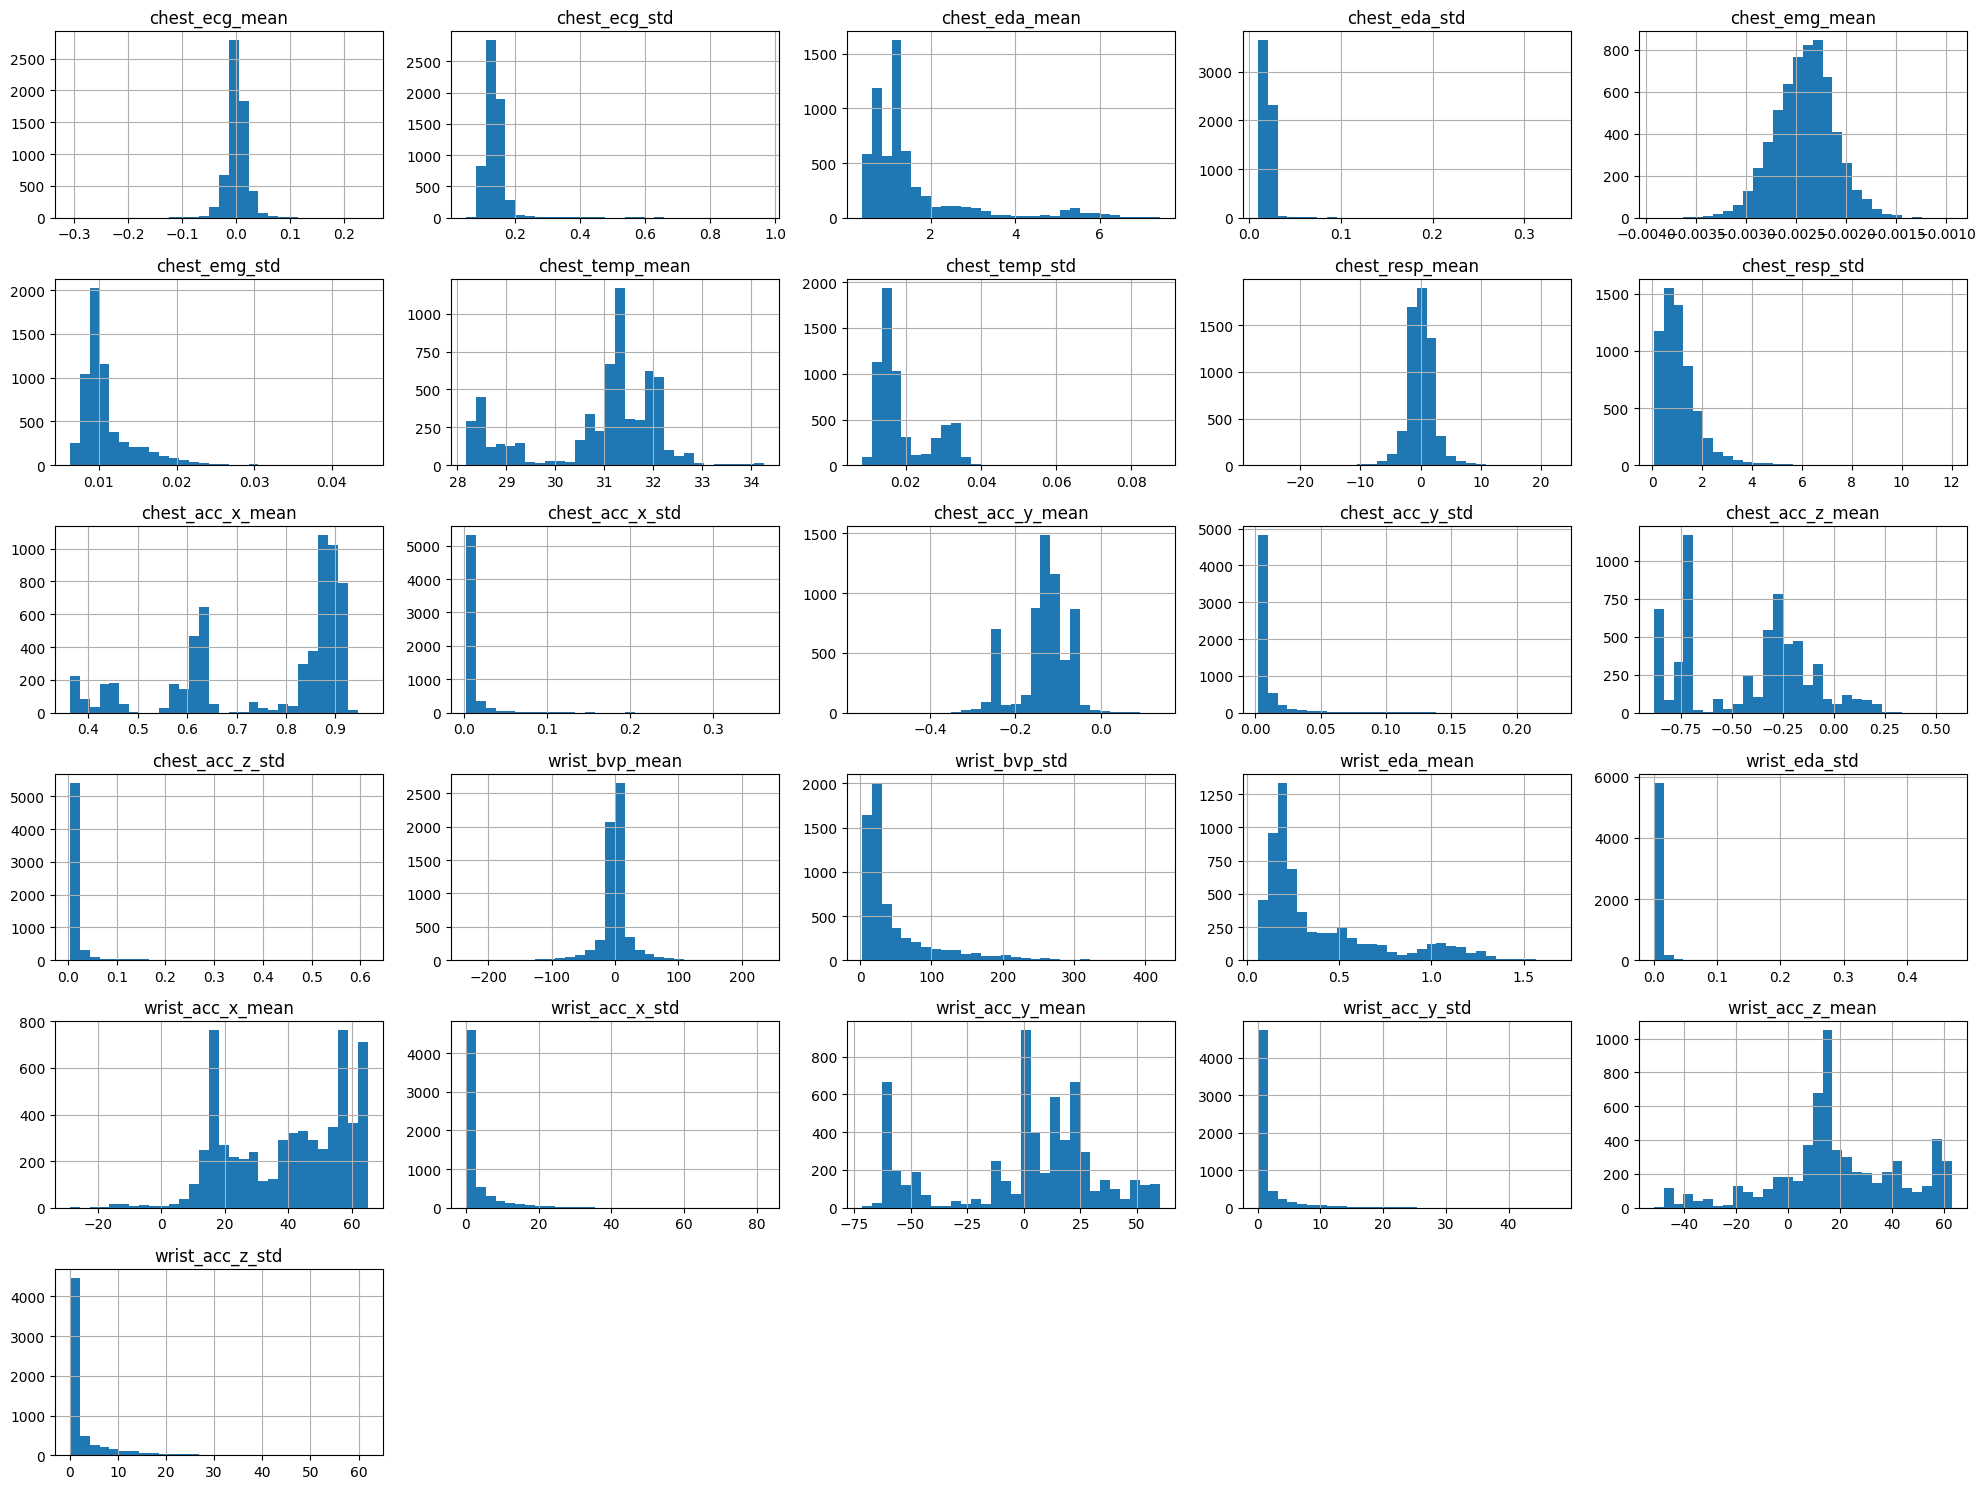

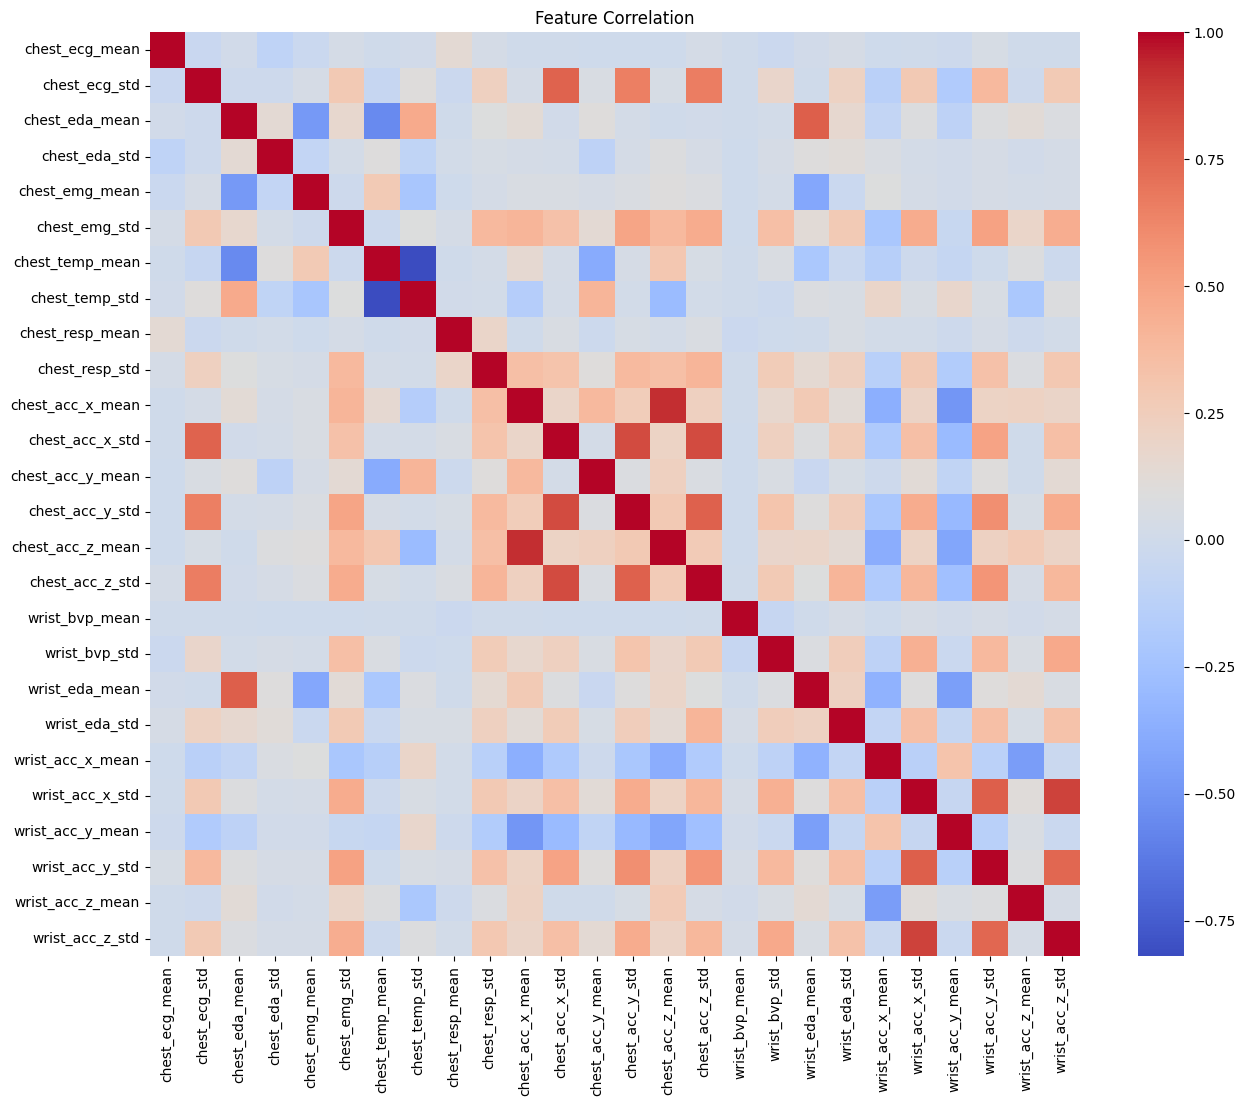

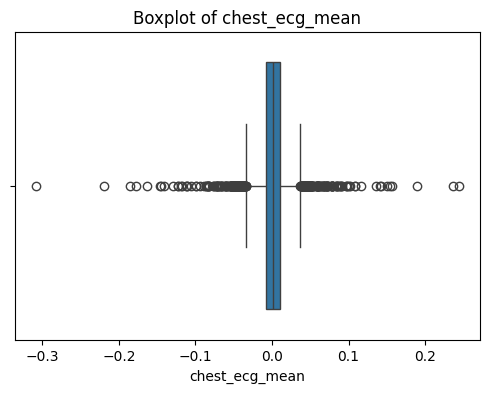

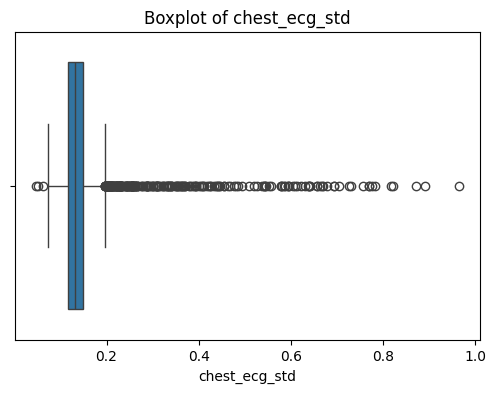

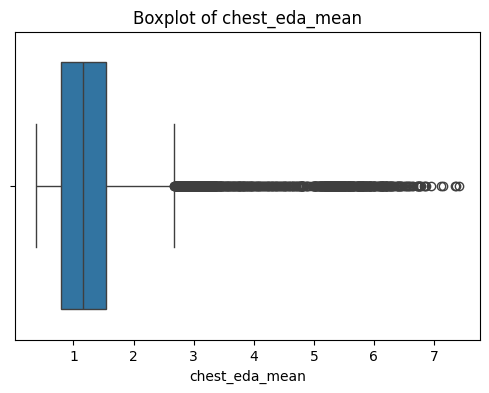

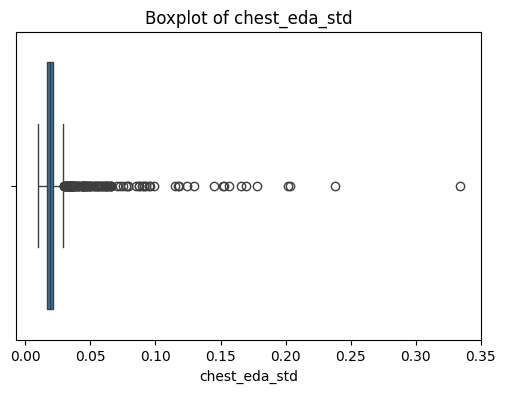

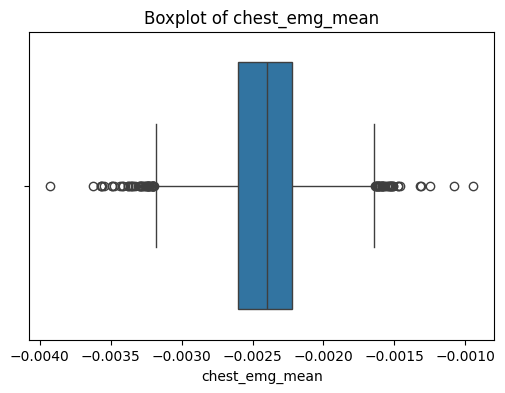

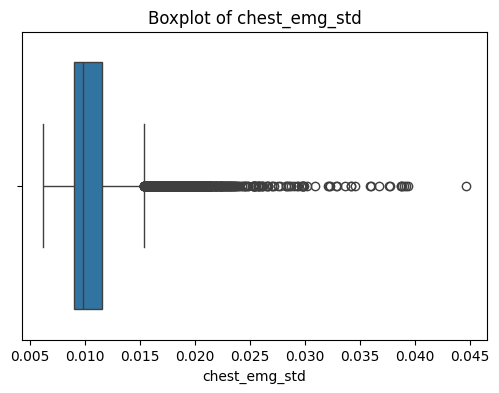

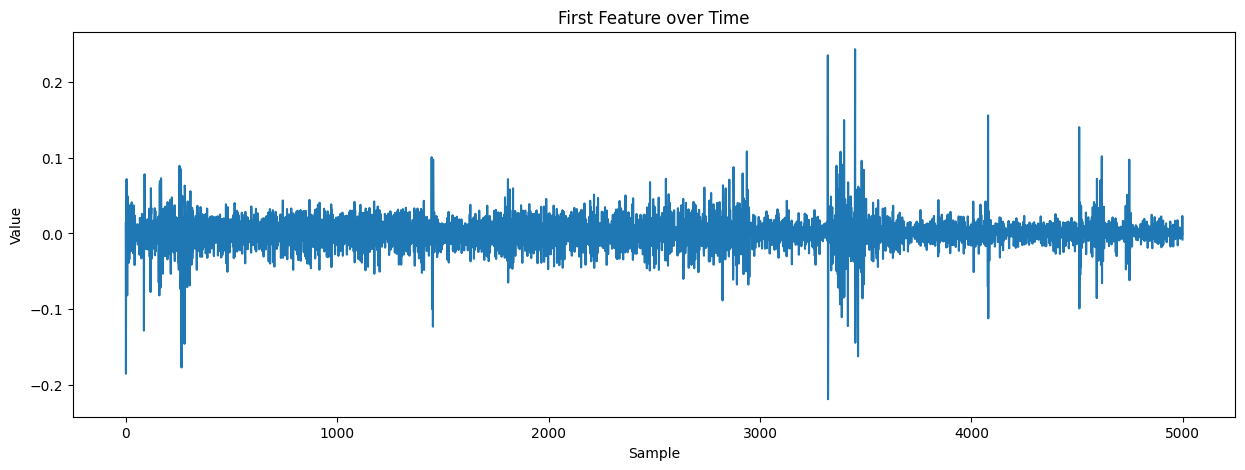

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Basic Info
print(df.info())

# 2. Check Missing Values
print(df.isnull().sum())

# 3. Summary Statistics
print(df.describe())

# 4. Label Distribution
plt.figure(figsize=(6,4))
df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Label Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# 5. Feature Distributions
feature_cols = df.columns.drop('label')  # drop label for now

df[feature_cols].hist(figsize=(20, 15), bins=30)
plt.tight_layout()
plt.show()

# 6. Correlation Heatmap
plt.figure(figsize=(15, 12))
corr = df[feature_cols].corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

# 7. Outlier Detection - Boxplots
for col in feature_cols[:6]:  # Just first few features for speed
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

# 8. Time Series Plot (Optional)
plt.figure(figsize=(15,5))
plt.plot(df[feature_cols[0]].values[:5000])  # First feature, first 5000 samples
plt.title('First Feature over Time')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.show()

In [ ]:
# Raw counts
print(df['label'].value_counts())

# Percentages
print(df['label'].value_counts(normalize=True) * 100)

label
0    3061
1    1144
4     768
2     615
3     362
6      65
7      64
Name: count, dtype: int64
label
0    50.353677
1    18.818885
4    12.633657
2    10.116796
3     5.954927
6     1.069255
7     1.052805
Name: proportion, dtype: float64


There is an imbalance in the class label.

In [ ]:
from imblearn.over_sampling import SMOTE

# Features and label
X = df.drop('label', axis=1)
y = df['label']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(pd.Series(y_resampled).value_counts())

label
0    3061
1    3061
2    3061
6    3061
4    3061
3    3061
7    3061
Name: count, dtype: int64


In [ ]:
# Define mapping
def map_to_bipolar_state(original_label):
    if original_label in [0, 3]:
        return 'euthymia'
    elif original_label in [1, 6]:
        return 'depression'
    elif original_label in [2, 4]:
        return 'mania'
    else:
        return None  # ignore label 7 (or you can decide)

# Apply mapping
df['bipolar_state'] = df['label'].apply(map_to_bipolar_state)

# Drop rows where bipolar_state is None (optional)
df = df.dropna(subset=['bipolar_state'])

print(df['bipolar_state'].value_counts())

bipolar_state
euthymia      3423
mania         1383
depression    1209
Name: count, dtype: int64


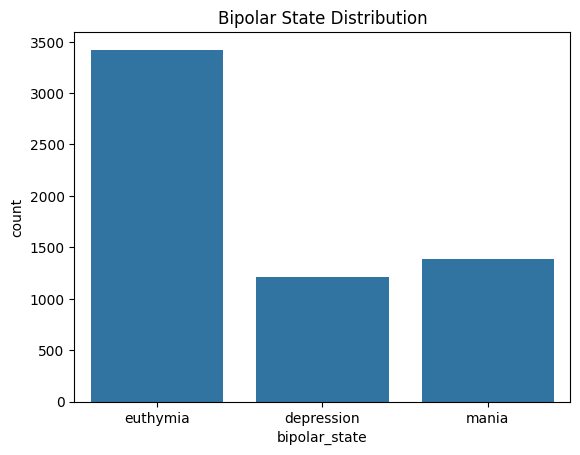

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='bipolar_state')
plt.title('Bipolar State Distribution')
plt.show()

In [ ]:
from sklearn.utils import resample

# Separate by class
euthymia = df[df['bipolar_state'] == 'euthymia']
depression = df[df['bipolar_state'] == 'depression']
mania = df[df['bipolar_state'] == 'mania']

# Find minimum class size
min_count = min(len(euthymia), len(depression), len(mania))

# Resample each class
euthymia_balanced = resample(euthymia, replace=False, n_samples=min_count, random_state=42)
depression_balanced = resample(depression, replace=False, n_samples=min_count, random_state=42)
mania_balanced = resample(mania, replace=False, n_samples=min_count, random_state=42)

# Combine back
df_balanced = pd.concat([euthymia_balanced, depression_balanced, mania_balanced])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_balanced['bipolar_state'].value_counts())

bipolar_state
euthymia      1209
depression    1209
mania         1209
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

X = df_balanced.drop(['label', 'bipolar_state'], axis=1)
y = df_balanced['bipolar_state']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

#### 4.0 Baseline Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  depression       1.00      0.99      0.99       242
    euthymia       0.98      0.99      0.99       242
       mania       0.99      1.00      0.99       242

    accuracy                           0.99       726
   macro avg       0.99      0.99      0.99       726
weighted avg       0.99      0.99      0.99       726



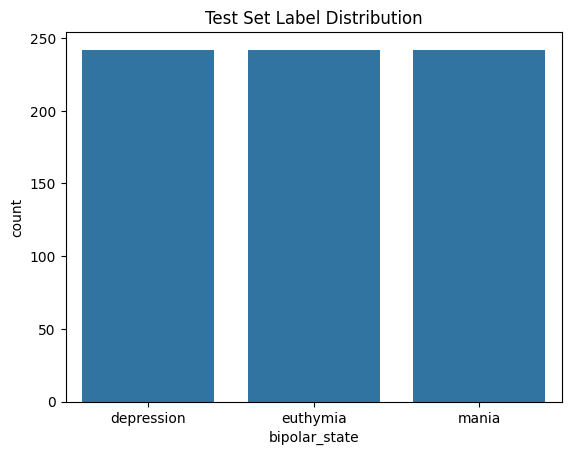

In [ ]:
sns.countplot(x=y_test)
plt.title("Test Set Label Distribution")
plt.show()

#### 4.0.1 Cross validation

In [ ]:
from sklearn.model_selection import cross_val_score

# Cross-validation
cv_scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')

print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean()}")
print(f"Standard Deviation: {cv_scores.std()}")

Cross-Validation Accuracy Scores: [0.99035813 0.99449036 0.99034483 0.98068966 0.98206897]
Mean Accuracy: 0.9875903866248693
Standard Deviation: 0.005309672732033338


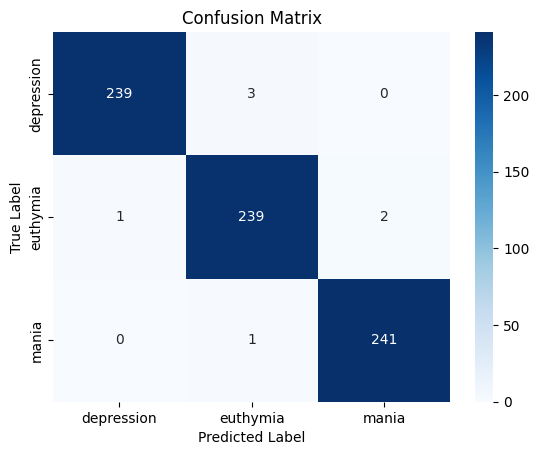

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Check depth and number of trees
print(f"Number of trees: {clf.n_estimators}")

Number of trees: 100


#### 5.0 Simple Dense Network - Deep Learning

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Train
history = model.fit(X_train, y_train_enc, epochs=20, validation_data=(X_test, y_test_enc))

Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5928 - loss: 2.0398 - val_accuracy: 0.8457 - val_loss: 0.5682
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.8559 - loss: 0.4449 - val_accuracy: 0.8554 - val_loss: 0.4578
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8990 - loss: 0.3216 - val_accuracy: 0.8884 - val_loss: 0.3811
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9016 - loss: 0.2770 - val_accuracy: 0.8774 - val_loss: 0.4643
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8915 - loss: 0.3412 - val_accuracy: 0.8719 - val_loss: 0.3703
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8947 - loss: 0.2947 - val_accuracy: 0.8774 - val_loss: 0.4684
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9022 - loss: 0.2807 - val_accuracy: 0.8912 - val_loss: 0.4074
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9094 - loss: 0.2730 - val_accuracy: 0.8788 - val_l

In [ ]:
# Evaluate on the validation dataset
loss, accuracy = model.evaluate(X_test, y_test_enc, verbose=1)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9156 - loss: 0.3166 
Validation Loss: 0.33197999000549316
Validation Accuracy: 0.910468339920044


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on the validation dataset
y_pred = model.predict(X_test)

# Get the class with the highest probability
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report (precision, recall, F1-score)
print(classification_report(y_test_enc, y_pred_classes))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_enc, y_pred_classes))

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       242
           1       0.84      0.90      0.87       242
           2       0.95      0.95      0.95       242

    accuracy                           0.91       726
   macro avg       0.91      0.91      0.91       726
weighted avg       0.91      0.91      0.91       726

Confusion Matrix:
[[214  28   0]
 [ 13 217  12]
 [  0  12 230]]


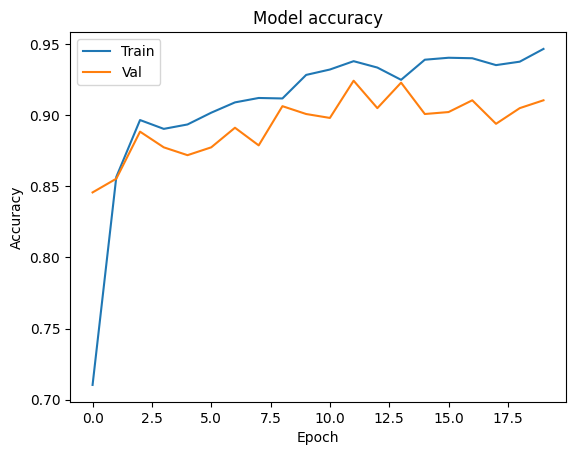

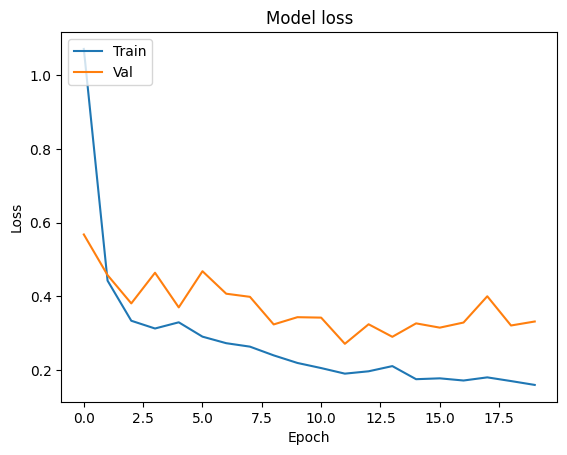

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()